#### Tutorial on manipulating MSI L1C product




Notes for co-authors of this file:-
1. The plot function for the radiance at the end of this file crashes after overloading the RAM
2. While building the radiance formula by using the markdown, unwanted artifacts are developed like this, this issue is linked to how the markdown is rendered by this version of Jupyter we are using: **d} on}
$$$ ]**
3. Installation of graphviz as a python package into the environment as well as installing this as an executable within the Linux system is required to run the 'visualise' function



In [1]:
from pathlib import Path

import datatree
import cartopy.crs as ccrs  # For static plotting
import cartopy.feature as cf
import geopandas  # For interactive plotting
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import xarray as xr

#from eopf.store.safe2 import XarrayStore
#from eopf.store.safe2 import EOSafeStore2
from eopf.common.constants import OpeningMode
from eopf.product.eo_variable import EOVariable

import fsspec


## Open the product


In [2]:
# Define the remote product path
remote_product_path = "https://eopf-public.s3.sbg.perf.cloud.ovh.net/eoproducts/S2MSIL1C_20231001T094031_N0509_R036_T33RUJ_T345.zarr.zip"

# Construct the fsspec mapper path
store = fsspec.get_mapper(f"zip::{remote_product_path}")

# Load it with datatree
dt = datatree.open_datatree(store, engine="zarr", consolidated=False, chunks={})

## Overview of the product content

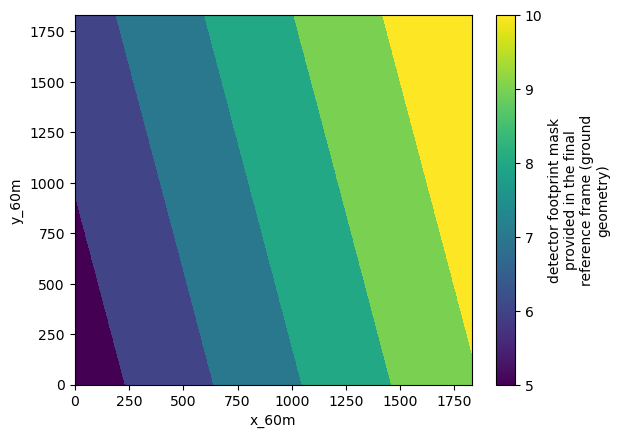

In [3]:
dt["conditions/msk_detfoo_b01"].plot()

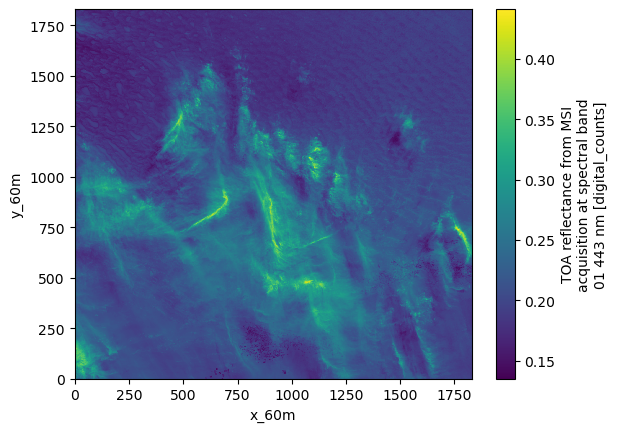

In [4]:
dt["measurements/reflectances_60m"]["b01_60m"].plot()


In [5]:
dt["measurements/reflectances_60m"]["b01_60m"].encoding["add_offset"]

-0.1

In [6]:
min,max,mean=dt["measurements/reflectances_60m"]["b01_60m"].data.max(), dt["measurements/reflectances_60m"]["b01_60m"].data.min(), dt["measurements/reflectances_60m"]["b01_60m"].data.mean()
min.compute(),max.compute(),mean.compute()

(0.44120000000000004, 0.1349, 0.21381266403893812)

In [7]:
r = dt["measurements/reflectances_10m"]["b04_10m"]
g = dt["measurements/reflectances_10m"]["b03_10m"]
b = dt["measurements/reflectances_10m"]["b02_10m"]

xr.Dataset(dict(r=r, g=g, b=b))
# Check indexes

<xarray.Dataset> Size: 3GB
Dimensions:  (y_10m: 10980, x_10m: 10980)
Dimensions without coordinates: y_10m, x_10m
Data variables:
    r        (y_10m, x_10m) float64 964MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    g        (y_10m, x_10m) float64 964MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
    b        (y_10m, x_10m) float64 964MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>

In [8]:
b02 = dt["measurements/reflectances_10m"]["b02_10m"]
b02

<xarray.DataArray 'b02_10m' (y_10m: 10980, x_10m: 10980)> Size: 964MB
dask.array<open_dataset-b02_10m, shape=(10980, 10980), dtype=float64, chunksize=(1830, 1830), chunktype=numpy.ndarray>
Dimensions without coordinates: y_10m, x_10m
Attributes:
    dimensions:  y_10m x_10m
    dtype:       <u2
    long_name:   TOA reflectance from MSI acquisition at spectral band 02 490 nm
    short_name:  b02_10m
    units:       digital_counts
    valid_max:   65535
    valid_min:   1

In [9]:
b02.dtype


dtype('float64')

In [10]:
b02.encoding


{'chunks': (1830, 1830),
 'preferred_chunks': {'y_10m': 1830, 'x_10m': 1830},
 'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': 0,
 'scale_factor': 0.0001,
 'add_offset': -0.1,
 'dtype': dtype('uint16'),
 'coordinates': 'y_10m x_10m'}

## Plot a RGB image


In [ ]:
rgb_band_paths = (
            f"measurements/reflectances_10m/b04_10m",
            f"measurements/reflectances_10m/b03_10m",
            f"measurements/reflectances_10m/b02_10m",
        )

concat = xr.concat(
        [dt[str(p)] for p in rgb_band_paths],  # type: ignore
        dim="band",
    )

ax = concat.plot.imshow()
ax.axes.set_aspect("equal")
plt.gca().invert_yaxis()

## Explore product geolocation

The following snippet shows an interactive map with the tile's footprint
### Interactive map



In [ ]:
gdf = geopandas.GeoDataFrame.from_features([{"type": "Feature", "geometry": dt.attrs["geometry"], "properties": dt.attrs["properties"]}])

Note: CRS is missing from the metadata, it must be set manually



In [ ]:
gdf = gdf.set_crs(4326)


In [ ]:
gdf.explore()

In [ ]:
gdf.crs


### Non-interactive map

The following snippet shows the location of the tile on a global map.




In [ ]:
def main():
    # Assume gdf is already defined somewhere before this function
    # Reproject to a projected CRS
    gdf_projected = gdf.to_crs(epsg=3857)  # Change to an appropriate projected CRS
    centroids = gdf_projected.centroid

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

    # Make the map global rather than have it zoom in to the extents of any plotted data
    ax.set_global()

    # ax.stock_img()
    ax.coastlines()

    # Transform back to geographic CRS for plotting
    gdf_centroids_geographic = centroids.to_crs(epsg=4326)

    ax.plot(
        gdf_centroids_geographic.x, 
        gdf_centroids_geographic.y, 
        "ro", 
        transform=ccrs.PlateCarree()
    )

    plt.show()


if __name__ == "__main__":
    main()

#### Plot georeferenced data


In [ ]:
# Define constant for plotting
L1C_PROJECTION = ccrs.epsg(32633)
DESIRED_PROJECTION = ccrs.PlateCarree()
FIGSIZE: tuple[int, int] = (12, 8)
RESOLUTION_CARTOPY: str = '110m'
#GEOGRAPHICAL_LIMITS: tuple[int, int, int, int] = (-20, 30, 10, 30)
GEOGRAPHICAL_LIMITS: tuple[int, int, int, int] = (10, 20, 24, 28)

# Speed up plot by sampling data every SKIP_EVERY pixels
SKIP_EVERY: int = 50

# Define plotting arguments for Polygon around the area of interest
POLYGON_THICKNESS: int = 1
POLYGON_COLOR: str = 'r'

# Get the geometry from the product and check that it correspond to the domain represented
geometry_from_product = np.squeeze(dt.attrs["geometry"]["coordinates"])
geometry_from_product

In [ ]:
_, ax = plt.subplots(subplot_kw={"projection": DESIRED_PROJECTION},
                    figsize=FIGSIZE)

# Plot cartopy geographic information
ax.coastlines(resolution=RESOLUTION_CARTOPY)
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.OCEAN)
ax.add_feature(cf.LAND)
gl = ax.gridlines(draw_labels=True, 
                  crs=DESIRED_PROJECTION)


b02 = dt["measurements/reflectances_10m"]["b02_10m"]
plt.contourf(b02[::SKIP_EVERY, ::SKIP_EVERY], transform=L1C_PROJECTION)
poly = mpatches.Polygon(geometry_from_product, 
                        closed=True, 
                        ec=POLYGON_COLOR, 
                        fill=False, 
                        lw=POLYGON_THICKNESS, 
                        transform=DESIRED_PROJECTION)
ax.add_patch(poly)
ax.set_extent(GEOGRAPHICAL_LIMITS, crs=DESIRED_PROJECTION)
cbar = plt.colorbar(orientation="horizontal")
cbar.set_label('b02_10m')
plt.tight_layout()

## Compute radiances

From: https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/product-types/level-1c$\text{radiance} = \text{reflectance} \times \cos\left(\text{radians}(\text{SunZenithAngle})\right) \times \text{solarIrradiance} \times \frac{U}{\pi}$

d}
$on}
$$
$$$$
\]


In [ ]:
U: float = dt.attrs["other_metadata"]["reflectance_correction_factor_from_the_Sun-Earth_distance_variation_computed_using_the_acquisition_date"]
U


In [ ]:
# Be carefull, Sun Zenith Angle is expressed on the angles grid (5km), it needs to be reprojected on the 10m grid for computing radiances
# cosinus is applied now because we can not interpolate angles using a linear interpolation (discontinuity at 0°)
# On the other hand, cosines can be interpolated
# cos_zsa_5km: EOVariable = np.cos(np.deg2rad(xdt[].conditions.geometry.sza))
# cos_zsa_5km

cos_sza_5km: EOVariable = np.cos(np.deg2rad(dt["conditions/geometry/sza"]))
cos_sza_5km

In [ ]:
# We will convert reflectances from band BAND to radiances
BAND: int = 2

# Band - 1 because Python list index starts at 0
solarIrradiance: float = np.float64(dt.attrs["properties"]["eo:bands"][BAND-1]["solar_illumination"])

In [ ]:
reflectance_b02_10m: EOVariable = dt["measurements/reflectances_10m/b02_10m"]
reflectance_b02_10m

In [ ]:
# Interpolate sza on the angles grid to the 10m grid
cos_sza_10m: xr.DataArray = cos_sza_5km.interp_like(reflectance_b02_10m)
cos_sza_10m.compute()

In [ ]:
# For simplicity, radiance computation assume that reflectances equal numerical counts

radiance = reflectance_b02_10m * cos_sza_10m * solarIrradiance * U / np.pi
radiance

Visualize computational graph (Needs to have graphviz package)


In [ ]:
radiance.data.visualize()


In [ ]:
#radiance.plot()
